In [13]:
# default_exp smoothing

# Smoothing

> Code for Simple Exponential Smoothing and Weighted Moving Average.

In [1]:
#hide
from nbdev.showdoc import *

In [2]:
#export
import numpy as np
from numba import jit
import pandas as pd

## Random Time Series

> Generate Random Time Series
> Include Seasonality, Trend, Level and Noise

In [10]:
#export
def random_time_series(
    num_points=30,
    level=3,
    trend_amplitude=1 / 3,
    sinus_amplitude=1,
    noise_amplitude=2 / 1,
    start=0,
    finish=4 * np.pi,
):

    interval = np.linspace(
        start,
        finish,
        num=num_points + 1,
    )

    season = np.sin(interval[:-1])
    trend = np.vectorize(lambda x: trend_amplitude * x)(interval[:-1])
    noise = noise_amplitude * np.random.random((num_points,))
    signal = level + season + trend + noise
    return interval, signal

## Simple Exponential Smoothing

In [23]:
#export
def __simple(
    ts,
    alpha=0.1,
):

    if alpha > 1 or alpha < 0:
        raise Exception("Alpha should be on the interval (0,1)")

    n = len(ts) + 1
    f = np.zeros((n,))

    f[0] = ts[0]

    for i in range(1, n - 1):
        f[i] = alpha * ts[i] + (1 - alpha) * (f[i - 1])

    f[n-1] = f[n - 2]
    return f

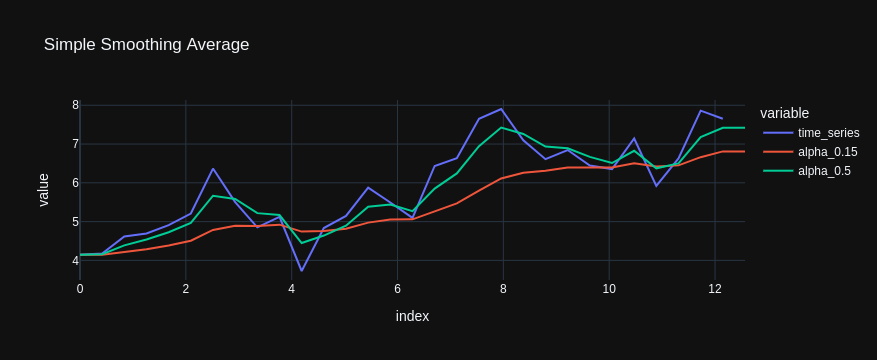

In [24]:
interval, d = random_time_series()
alpha1, alpha2 = 0.15, 0.5

time_series = np.append(d, [np.nan])

simple1 = __simple(
    ts=d,
    alpha=alpha1,
)

simple2 = __simple(
    ts=d,
    alpha=alpha2,
)

df = pd.DataFrame(
    {
        'time_series': time_series,
        f'alpha_{alpha1}': simple1,
        f'alpha_{alpha2}': simple2,
    },
    index=interval,
)
df.index = interval

fig = df.plot(backend='plotly', title=f'Simple Smoothing Average')

fig.update_layout(template="plotly_dark",)

## Double Exponential Smoothing

In [50]:
#export
@jit(nopython=True)
def __double(
    ts,
    alpha=0.1,
    beta=0.1,
    s_0=None,
    b_0=None,
    m=1,
):

    if alpha > 1 or alpha < 0:
        raise Exception("alpha should be on the interval (0,1)")
    if beta > 1 or beta < 0:
        raise Exception("beta should be on the interval (0,1)")

    n = len(ts) + m
    s = np.full((n,), np.nan)
    b = np.full((n,), np.nan)
    f = np.full((n,), np.nan)
    tss = np.append(ts, np.full(m, np.nan))

    s[0] = tss[0] if s_0 is None else s_0
    b[0] = tss[1] - tss[0] if b_0 is None else b_0

    for i in range(1, n):
        s[i] = alpha * tss[i] + (1 - alpha) * (s[i - 1] + b[i - 1])
        b[i] = beta * (s[i] - s[i - 1]) + (1 - beta) * b[i - 1]

        f[i - 1 + m] = s[i - 1] + m * b[i - 1]

    return f

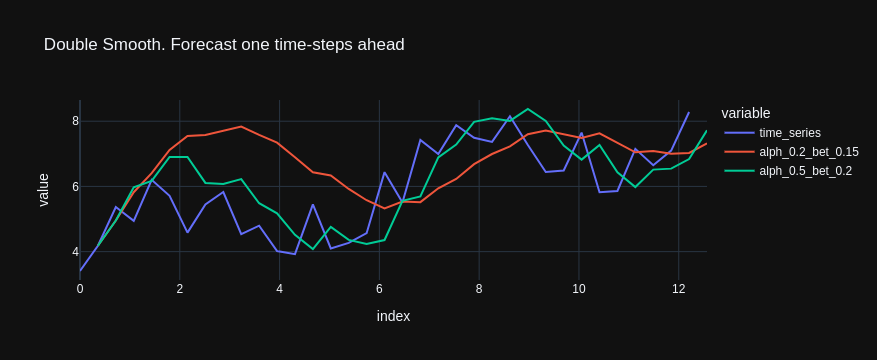

In [51]:
interval, d = random_time_series(num_points=35,)
alpha1, alpha2 = 0.2, 0.5
beta1, beta2 = 0.15, 0.2
time_series = np.append(d, [np.nan for _ in range(m)])

double1 = __double(
    ts=d,
    alpha=alpha1,
    beta=beta1,
    m=1,
)

double2 = __double(
    ts=d,
    beta=beta2,
    alpha=alpha2,
    m=1,
)

df = pd.DataFrame(
    {
        'time_series': time_series,
        f'alph_{alpha1}_bet_{beta1}': double1,
        f'alph_{alpha2}_bet_{beta2}': double2,
    },
    index=interval,
)
df.index = interval

fig = df.plot(
    backend='plotly',
    title=f'Double Smooth. Forecast one time-steps ahead',
)

fig.update_layout(template="plotly_dark",)

## Triple Exponential Smoothing

> Holt-Winters Method

In [70]:
#export
@jit(nopython=True)
def holt_winters(
    ts,
    l=1,
    alpha=0.1,
    beta=0.1,
    gamma=0.1,
    s_0=None,
    b_0=None,
    m=1,
):

    if alpha > 1 or alpha < 0:
        raise Exception("alpha should be on the interval (0,1)")
    if beta > 1 or beta < 0:
        raise Exception("beta should be on the interval (0,1)")
    if gamma > 1 or gamma < 0:
        raise Exception("gamma should be on the interval (0,1)")

    if (l <= 0) and (l - int(l) != 0):
        raise Exception("l should be a Natural Number")

    n = len(ts) + m
    #complete cycles
    N = (n - m) // l

    if N == 0:
        raise Exception("it should be at least one complete cycle")

    s = np.full((n,), np.nan)
    b = np.full((n,), np.nan)
    f = np.full((n,), np.nan)
    c = np.full((n,), np.nan)
    A = np.full((N,), np.nan)

    tss = np.append(ts, np.full(m, np.nan))

    s[0] = tss[0] if s_0 is None else s_0

    b[0] = (1 / l**2) * np.sum(tss[l:2 * l] - tss[:l])

    for j in range(1, N + 1):
        A[j - 1] = (1 / l) * np.sum(tss[l * (j - 1):l * (j - 1) + l])

    for i in range(l):
        c[i] = (1 / N) * np.sum(tss[i:l * (N - 1) + i + 1:l] / A)

    for i in range(1, n):
        s[i] = alpha * (tss[i] - c[i - l]) + (1 - alpha) * (s[i - 1] + b[i - 1])
        b[i] = beta * (s[i] - s[i - 1]) + (1 - beta) * b[i - 1]
        c[i] = gamma * (tss[i] - s[i - 1] - b[i - 1]) + (1 - gamma) * c[i - l]

        f[i - 1 + m] = s[i - i] + m * b[i] + c[i - l + 1 + ((m - 1) % l)]
        print(i-1)

    print(l, n, m)
    return f

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
4 36 1


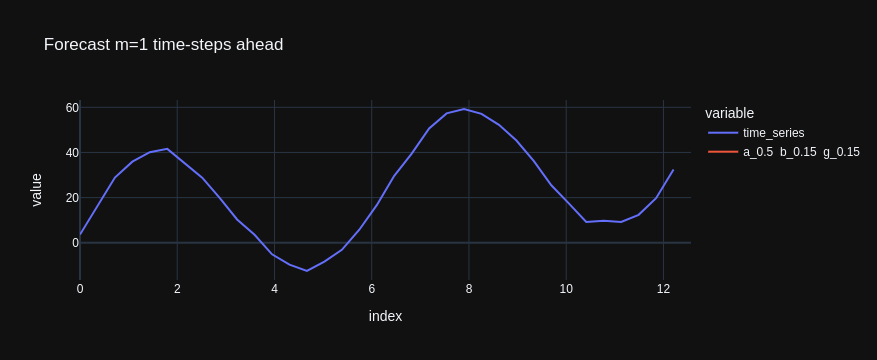

In [71]:
num_points = 35
m = 1
l = 4
interval = np.linspace(
    0,
    l * np.pi,
    num=num_points + m,
)

level = 3
season = (30 / 1) * np.sin(interval[:-m])
trend = np.vectorize(lambda x: (3 / 1) * x)(interval[:-m])
noise = (4 / 1) * np.random.random((num_points,))
d = level + season + trend + noise

alpha1, alpha2 = 0.5, 0.5
beta1, beta2 = 0.15, 0.2
gamma1 = 0.15

time_series = np.append(d, [np.nan for _ in range(m)])

holtwinters1 = holt_winters(
    ts=d,
    l=l,
    alpha=alpha1,
    beta=beta1,
    gamma=gamma1,
    m=m,
)

df = pd.DataFrame(
    {
        'time_series': time_series,
        f'a_{alpha1}\n b_{beta1}\n g_{gamma1}': holtwinters1,
        # f'alph_{alpha2}_bet_{beta2}': smoothing2,
    },
    index=interval,
)
df.index = interval

fig = df.plot(backend='plotly', title=f'Forecast m={m} time-steps ahead')

fig.update_layout(template="plotly_dark",)

In [ ]:
help(np.linspace)

## ...

## Dataframes and Figures

> Generates a Time Series Dataframe and a Figure Object

> The Values of The Time  Series are Simulated

> Includes Forecasting with Moving Averages 

In [21]:
#export
def SIMPLE(*args):
    interval, d = random_time_series()

    time_series = {'time_series': np.append(d, [np.nan])}

    preds = {f'alpha_{alpha}': __simple(
        ts=d,
        alpha=alpha,
    ) for alpha in args}

    time_series.update(preds)

    df = pd.DataFrame(
        time_series,
        index=interval,
    )
    df.index = interval

    fig = df.plot(
        backend='plotly',
        title=f'Simple Smoothing Average',
    )

    fig.update_layout(template="plotly_dark",)

    return df, fig

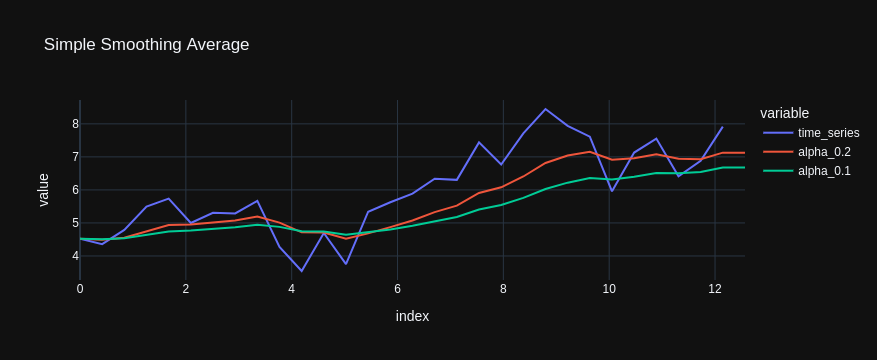

In [22]:
_, fig = SIMPLE(.2, .1)
fig.show()

In [77]:
#export
def DOUBLE(*args):

    interval, d = random_time_series(num_points=35)

    time_series = {'time_series': np.append(d, [np.nan])}

    preds = {
        f'{ab}': __double(
            ts=d,
            alpha=ab[0],
            beta=ab[1],
            m=1,
        ) for ab in args
    }

    time_series.update(preds)

    df = pd.DataFrame(
        time_series,
        index=interval,
    )
    df.index = interval

    fig = df.plot(
        backend='plotly',
        title=f'Double Smooth. Forecast one time-steps ahead',
    )

    fig.update_layout(template="plotly_dark",)

    return df, fig

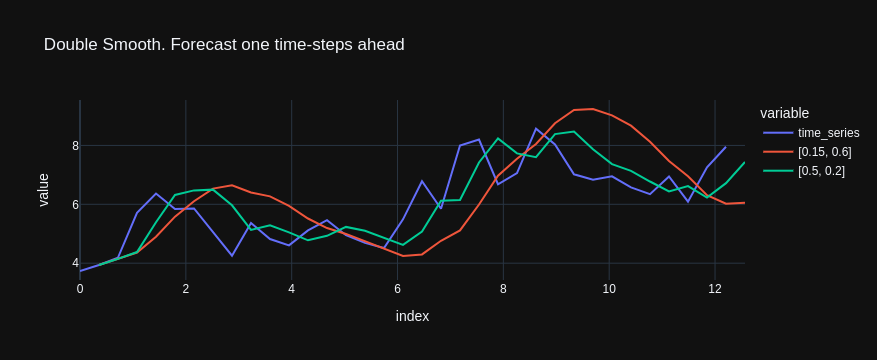

In [81]:
_, fig = DOUBLE(
    [.15, .6],
    [.5, .2],
)

fig.show()